In [445]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
# from statsmodels.tsa.statespace.kalman_filter import KalmanFilter

In [446]:
# df = pd.read_csv("../data/2020-08-25T06_26_17.629Z.csv", parse_dates=[0])
# df = pd.read_csv("../data/2020-08-25T06_11_15.569Z.csv", parse_dates=[0])
# graph_samplerate = 1
# rps = 2
df = pd.read_csv("../data/2020-08-25T11_43_19.036Z.csv")
graph_samplerate = 20 # seaborn doesn't like many points
rps = 100 # records per second

In [447]:
df

,time,aX,aY,aZ,gX,gY,gZ
0,196553,0.997681,-0.030640,-0.093262,0.549316,-2.502441,-0.427246
1,196573,0.996460,-0.036011,-0.088989,0.793457,-2.441406,0.000000
2,196583,0.998413,-0.040161,-0.093994,0.366211,-2.502441,0.000000
3,196593,1.000000,-0.048218,-0.090088,0.488281,-2.441406,0.000000
4,196603,0.999634,-0.047241,-0.092041,0.610352,-2.502441,-0.122070
...,...,...,...,...,...,...,...
3098,237279,0.994141,-0.128662,-0.058838,0.671387,-2.197266,-0.427246
3099,237289,0.996704,-0.130371,-0.061279,0.793457,-2.197266,-0.610352
3100,237299,0.997192,-0.132690,-0.060303,0.915527,-2.075195,-0.793457
3101,237309,0.994751,-0.128174,-0.058105,0.976562,-2.075195,-0.915527


<AxesSubplot:xlabel='time', ylabel='aZ'>

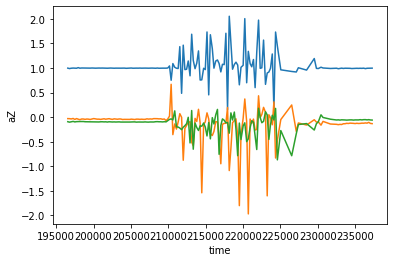

In [448]:
dfsample = df.iloc[::graph_samplerate]
sns.lineplot(data=dfsample, x="time", y="aX")
sns.lineplot(data=dfsample, x="time", y="aY")
sns.lineplot(data=dfsample, x="time", y="aZ")

/home/dlowl/git/wearable-my-foot/notebooks/env/lib64/python3.8/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


<AxesSubplot:xlabel='time', ylabel='aZ'>

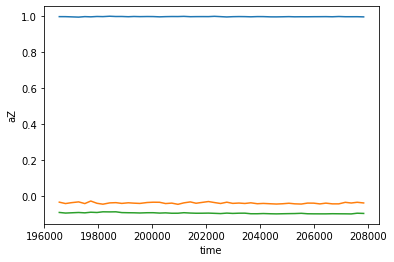

In [449]:
_df = df.iloc[:10*rps]
_df.loc[:,["aX"]] = sp.ndimage.median_filter(_df.loc[:,["aX"]], 5)
_df.loc[:,["aY"]] = sp.ndimage.median_filter(_df.loc[:,["aY"]], 5)
_df.loc[:,["aZ"]] = sp.ndimage.median_filter(_df.loc[:,["aZ"]], 5)
# _df = df.iloc[30:90]
_dfsample = _df.iloc[::graph_samplerate]
sns.lineplot(data=_dfsample, x="time", y="aX")
sns.lineplot(data=_dfsample, x="time", y="aY")
sns.lineplot(data=_dfsample, x="time", y="aZ")

In [450]:
ground_vector = _df.loc[:,["aX", "aY", "aZ"]].mean()

In [451]:
display("Ground vector",ground_vector.values,"magnitude",np.sqrt((ground_vector**2).sum()))

'Ground vector'

array([ 0.9977489 , -0.04082556, -0.0972677 ])

'magnitude'

1.0033098246317387

In [452]:
acceleration = df.loc[:,["aX", "aY", "aZ"]] - ground_vector
acceleration["time"] = df.time

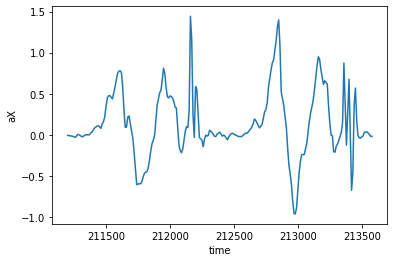

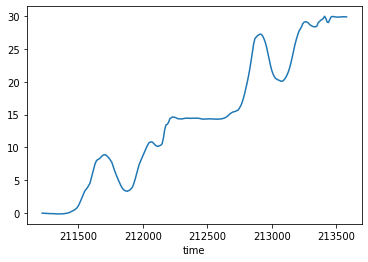

In [453]:
a, b = int(12.7 * rps), int(14.8 * rps)
# a, b = int(0 * rps), int(10 * rps)
sample = acceleration.iloc[a:b]
# Median filtering removes noise, but the integration results are virtually the same
# size = 13
# sample.loc[:,["aX"]] = sp.ndimage.median_filter(sample.loc[:,["aX"]], size)
# sample.loc[:,["aY"]] = sp.ndimage.median_filter(sample.loc[:,["aY"]], size)
# sample.loc[:,["aZ"]] = sp.ndimage.median_filter(sample.loc[:,["aZ"]], size)
velsample = sp.integrate.cumtrapz(y=sample.aX.values[1:])
sns.lineplot(data=sample, x="time", y="aX")
plt.show()
sns.lineplot(x=sample.time[2:], y=velsample)
plt.show()
# sns.lineplot(data=sample, x="time", y="aY")
# sns.lineplot(data=sample, x="time", y="aZ")


<AxesSubplot:xlabel='time', ylabel='aZ'>

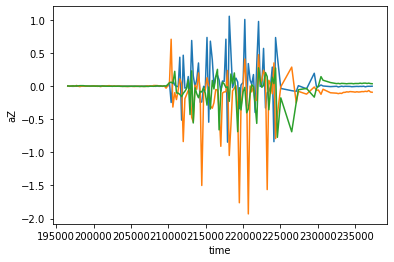

In [454]:
_a = acceleration.iloc[::graph_samplerate]
sns.lineplot(data=_a, x="time", y="aX")
sns.lineplot(data=_a, x="time", y="aY")
sns.lineplot(data=_a, x="time", y="aZ")

In [455]:
velocity = pd.DataFrame(sp.integrate.cumtrapz(y=acceleration.loc[:, ["aX", "aY", "aZ"]], x=acceleration.time, axis=0), columns=["vX", "vY", "vZ"])
velocity["time"] = acceleration.time
velocity["magnitude"] = (velocity.loc[:,["vX", "vY", "vZ"]]**2).sum(axis=1)

<AxesSubplot:xlabel='time', ylabel='vZ'>

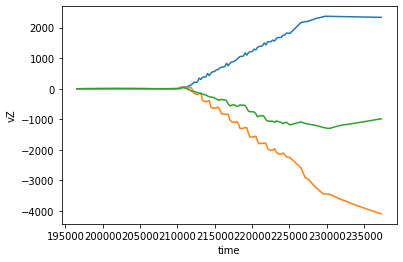

In [456]:
vsample = velocity.iloc[::graph_samplerate]
sns.lineplot(data=vsample, x="time", y="vX")
sns.lineplot(data=vsample, x="time", y="vY")
sns.lineplot(data=vsample, x="time", y="vZ")

<AxesSubplot:xlabel='time', ylabel='magnitude'>

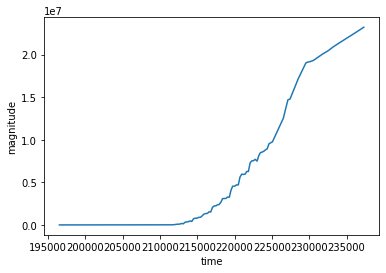

In [457]:
sns.lineplot(data=vsample, x="time", y="magnitude")

In [458]:
acceleration["magnitude"] = np.sqrt((acceleration.loc[:,["aX", "aY", "aZ"]]**2).sum(axis=1))

KeyboardInterrupt: 

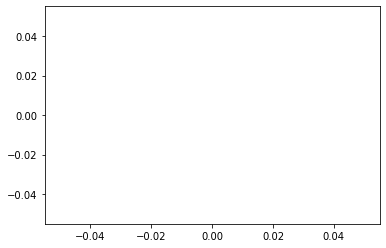

In [307]:
sns.lineplot(data=acceleration, x="datetime", y="magnitude")

In [210]:
acceleration.loc[1:, "dt"] = [(a - b) / pd.Timedelta("1ms") for a, b in zip(acceleration.datetime.loc[1:], acceleration.datetime.iloc[:-1])]

In [211]:
acceleration.loc[1:,["dvX", "dvY", "dvZ"]] = acceleration.loc[1:, ["aX", "aY", "aZ"]].mul(acceleration.dt.loc[1:], axis=0)

In [212]:
acceleration

,aX,aY,aZ,datetime,magnitude,dt,dvX,dvY,dvZ
0,0.004281,0.010099,-0.040560,2020-08-25 06:10:00.035000+00:00,0.042017,NaN,NaN,NaN,NaN
1,-0.004264,0.023649,-0.036287,2020-08-25 06:10:00.491000+00:00,0.043523,456.0,NaN,NaN,NaN
2,-0.004264,0.023649,-0.036287,2020-08-25 06:10:00.493000+00:00,0.043523,2.0,NaN,NaN,NaN
3,-0.002799,0.021818,-0.032869,2020-08-25 06:10:01.038000+00:00,0.039551,545.0,NaN,NaN,NaN
4,-0.002799,0.021818,-0.032869,2020-08-25 06:10:01.044000+00:00,0.039551,6.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
284,0.000130,-0.058993,0.021818,2020-08-25 06:11:11.018000+00:00,0.062898,29.0,NaN,NaN,NaN
285,-0.001335,-0.061190,0.029508,2020-08-25 06:11:11.488000+00:00,0.067946,470.0,NaN,NaN,NaN
286,-0.001335,-0.061190,0.029508,2020-08-25 06:11:11.515000+00:00,0.067946,27.0,NaN,NaN,NaN
287,0.001229,-0.061312,0.028532,2020-08-25 06:11:11.991000+00:00,0.067637,476.0,NaN,NaN,NaN


In [213]:
df2 = acceleration.loc[1:, ["aX", "aY", "aZ"]].mul(acceleration.dt[1:], axis=0).cumsum(axis=0)
df2

,aX,aY,aZ
1,-1.944538,10.783984,-16.547070
2,-1.953066,10.831282,-16.619645
3,-3.478786,22.722111,-34.533506
4,-3.495583,22.853019,-34.730723
5,-4.975065,27.452628,-52.762950
...,...,...,...
284,1382.021047,-8545.413332,-3969.724718
285,1381.393768,-8574.172528,-3955.855741
286,1381.357733,-8575.824652,-3955.059012
287,1381.942672,-8605.009092,-3941.477827


<AxesSubplot:xlabel='datetime', ylabel='aX'>

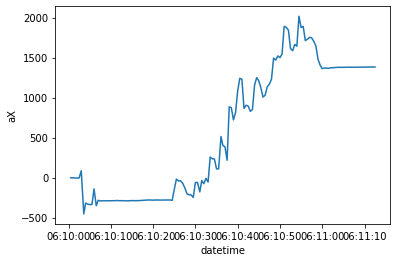

In [214]:
sns.lineplot(x=acceleration.datetime[1:], y=df2.aX)
# sns.lineplot(data=df2, x=acceleration.datetime[1:], y="aY")
# sns.lineplot(data=df2, x=acceleration.datetime[1:], y="aZ")

In [215]:
[(a - b) / pd.Timedelta("1ms") for a, b in zip(acceleration.datetime.loc[1:], acceleration.datetime.iloc[:-1])]

[456.0,
 2.0,
 545.0,
 6.0,
 450.0,
 5.0,
 490.0,
 6.0,
 495.0,
 7.0,
 491.0,
 4.0,
 598.0,
 7.0,
 390.0,
 37.0,
 461.0,
 28.0,
 477.0,
 6.0,
 491.0,
 46.0,
 454.0,
 33.0,
 518.0,
 5.0,
 447.0,
 5.0,
 495.0,
 6.0,
 488.0,
 39.0,
 464.0,
 6.0,
 494.0,
 32.0,
 465.0,
 25.0,
 480.0,
 2.0,
 494.0,
 36.0,
 465.0,
 2.0,
 497.0,
 4.0,
 499.0,
 5.0,
 491.0,
 23.0,
 484.0,
 5.0,
 543.0,
 29.0,
 416.0,
 33.0,
 477.0,
 5.0,
 586.0,
 4.0,
 401.0,
 4.0,
 496.0,
 5.0,
 490.0,
 34.0,
 471.0,
 30.0,
 469.0,
 4.0,
 494.0,
 22.0,
 529.0,
 4.0,
 446.0,
 5.0,
 494.0,
 4.0,
 498.0,
 4.0,
 595.0,
 36.0,
 363.0,
 20.0,
 485.0,
 4.0,
 491.0,
 35.0,
 466.0,
 31.0,
 465.0,
 25.0,
 479.0,
 5.0,
 554.0,
 33.0,
 405.0,
 21.0,
 479.0,
 4.0,
 498.0,
 6.0,
 496.0,
 2.0,
 497.0,
 4.0,
 496.0,
 3.0,
 496.0,
 6.0,
 492.0,
 4.0,
 499.0,
 3.0,
 502.0,
 2.0,
 490.0,
 5.0,
 497.0,
 10.0,
 492.0,
 2.0,
 545.0,
 3.0,
 447.0,
 15.0,
 485.0,
 6.0,
 495.0,
 4.0,
 500.0,
 2.0,
 497.0,
 2.0,
 496.0,
 4.0,
 504.0,
 1.0,
 493.0,
 4.

<AxesSubplot:xlabel='datetime', ylabel='gZ'>

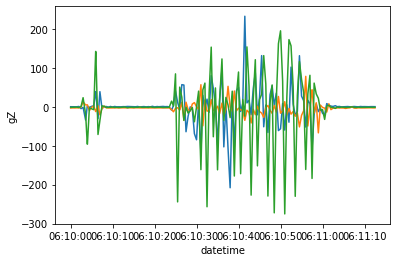

In [216]:
sns.lineplot(data=df, x="datetime", y="gX")
sns.lineplot(data=df, x="datetime", y="gY")
sns.lineplot(data=df, x="datetime", y="gZ")